# TRANSFER LEARNING PROJECT

## Based on PyTorch Tutorial

In [72]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 27.1 MB/s eta 0:00:00


In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from typing import Dict, List, Optional, Tuple, Any
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve, precision_recall_curve, matthews_corrcoef
from torchmetrics import Accuracy, Precision, Recall, F1Score, MatthewsCorrCoef, AUROC, AveragePrecision
import seaborn as sns
from tempfile import TemporaryDirectory

cudnn.benchmark: bool = True
plt.ion()

## Extracting data from Google Disk

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [84]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms: Dict[str, transforms.Compose] = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir: str = '/content/drive/MyDrive/hymenoptera_data'
image_datasets: Dict[str, datasets.ImageFolder] = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders: Dict[str, torch.utils.data.DataLoader] = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes: Dict[str, int] = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names: List[str] = image_datasets['train'].classes

# device: str = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Visualising the dataset images

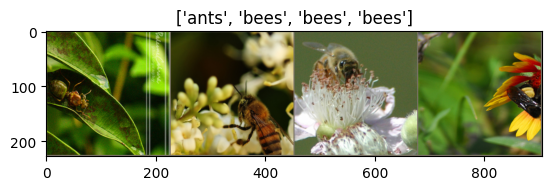

In [85]:
def imshow(inp: torch.Tensor, title: str = None) -> None:
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean: np.ndarray = np.array([0.485, 0.456, 0.406])
    std: np.ndarray = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs: torch.Tensor
classes: torch.Tensor
inputs, classes = next(iter(dataloaders['train']))
out: torch.Tensor = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [119]:
def plot_confusion_matrix(labels: List[int], preds: List[int], class_names: List[str]) -> None:
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_training_metrics(metrics: Dict[str, List[float]], learning_rates: List[float], val_metrics: Dict[str, List[float]], plot_roc_pr: bool = True) -> None:
    epochs = range(len(metrics['train_loss']))

    # Convert metrics to numpy arrays for plotting
    train_loss = np.array(metrics['train_loss'])
    val_loss = np.array(metrics['val_loss'])
    train_acc = np.array(metrics['train_acc'])
    val_acc = np.array(metrics['val_acc'])

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss', color='#1f77b4')
    plt.plot(epochs, val_loss, label='Validation Loss', color='#ff7f0e')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy', color='#1f77b4')
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='#ff7f0e')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plot Learning Rate
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, learning_rates, label='Learning Rate', color='#2ca02c')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot additional validation metrics
    if val_metrics:
        # Sklearn metrics
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1)
        plt.plot(epochs, val_metrics.get('precision_skl', [0] * len(epochs)), label='Precision', color='#1f77b4')
        plt.plot(epochs, val_metrics.get('recall_skl', [0] * len(epochs)), label='Recall', color='#ff7f0e')
        plt.plot(epochs, val_metrics.get('f1_skl', [0] * len(epochs)), label='F1', color='#2ca02c')
        plt.title('Precision, Recall, and F1 Score (Sklearn)')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True)

        plt.subplot(2, 2, 2)
        plt.plot(epochs, val_metrics.get('specificity_skl', [0] * len(epochs)), label='Specificity', color='#d62728')
        plt.plot(epochs, val_metrics.get('mcc_skl', [0] * len(epochs)), label='MCC', color='#9467bd')
        plt.title('Specificity and MCC (Sklearn)')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True)

        # Torchmetrics metrics
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1)
        plt.plot(epochs, val_metrics.get('precision_torch', [0] * len(epochs)), label='Precision', color='#1f77b4')
        plt.plot(epochs, val_metrics.get('recall_torch', [0] * len(epochs)), label='Recall', color='#ff7f0e')
        plt.plot(epochs, val_metrics.get('f1_torch', [0] * len(epochs)), label='F1', color='#2ca02c')
        plt.plot(epochs, val_metrics.get('accuracy_torch', [0] * len(epochs)), label='Accuracy', color='#ff9896')
        plt.title('Precision, Recall, F1, and Accuracy (Torchmetrics)')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True)

        plt.subplot(2, 2, 2)
        plt.plot(epochs, val_metrics.get('mcc_torch', [0] * len(epochs)), label='MCC', color='#9467bd')
        plt.title('MCC (Torchmetrics)')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True)

        if plot_roc_pr and len(val_metrics.get('roc_auc_skl', [])) > 0 and len(val_metrics.get('roc_auc_torch', [])) > 0:
            # Sklearn ROC and PR
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(epochs, val_metrics.get('roc_auc_skl', [0] * len(epochs)), label='ROC-AUC', color='#8c564b')
            plt.title('ROC-AUC Score (Sklearn)')
            plt.xlabel('Epoch')
            plt.ylabel('ROC-AUC')
            plt.legend()
            plt.grid(True)

            plt.subplot(1, 2, 2)
            plt.plot(epochs, val_metrics.get('pr_auc_skl', [0] * len(epochs)), label='PR-AUC', color='#e377c2')
            plt.title('PR-AUC Score (Sklearn)')
            plt.xlabel('Epoch')
            plt.ylabel('PR-AUC')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # Torchmetrics ROC and PR
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(epochs, val_metrics.get('roc_auc_torch', [0] * len(epochs)), label='ROC-AUC', color='#8c564b')
            plt.title('ROC-AUC Score (Torchmetrics)')
            plt.xlabel('Epoch')
            plt.ylabel('ROC-AUC')
            plt.legend()
            plt.grid(True)

            plt.subplot(1, 2, 2)
            plt.plot(epochs, val_metrics.get('pr_auc_torch', [0] * len(epochs)), label='PR-AUC', color='#e377c2')
            plt.title('PR-AUC Score (Torchmetrics)')
            plt.xlabel('Epoch')
            plt.ylabel('PR-AUC')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            plt.tight_layout()
            plt.show()

## Training the model

In [125]:
def train_model(model: nn.Module,
                criterion: nn.Module,
                optimizer: optim.Optimizer,
                scheduler: lr_scheduler._LRScheduler,
                num_epochs: int = 25,
                patience: int = 5) -> Tuple[nn.Module, Dict[str, List[float]], List[float], Dict[str, List[float]]]:
    since: float = time.time()
    best_acc: float = 0.0
    best_loss: float = float('inf')
    epochs_no_improve: int = 0
    early_stop: bool = False

    accuracy = Accuracy(task="binary").to(device)
    precision = Precision(task="binary").to(device)
    recall = Recall(task="binary").to(device)
    f1 = F1Score(task="binary").to(device)
    mcc = MatthewsCorrCoef(task="binary").to(device)
    auroc = AUROC(task="binary").to(device)
    pr_auc = AveragePrecision(task="binary").to(device)

    # Lists to store metrics for plotting
    train_losses: List[float] = []
    val_losses: List[float] = []
    train_accuracies: List[float] = []
    val_accuracies: List[float] = []
    learning_rates: List[float] = []
    val_metrics: Dict[str, List[float]] = {
        'precision_skl': [], 'recall_skl': [], 'f1_skl': [], 'specificity_skl': [], 'mcc_skl': [], 'roc_auc_skl': [], 'pr_auc_skl': [],
        'accuracy_torch': [], 'precision_torch': [], 'recall_torch': [], 'f1_torch': [], 'mcc_torch': [], 'roc_auc_torch': [], 'pr_auc_torch': []
    }

    with TemporaryDirectory() as tempdir:
        best_model_params_path: str = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        for epoch in range(num_epochs):
            if early_stop:
                print("Early stopping triggered.")
                break
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)
            current_lr: float = optimizer.param_groups[0]['lr']
            learning_rates.append(current_lr)
            print(f'Learning Rate: {current_lr:.6f}')
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss: float = 0.0
                running_corrects: float = 0.0
                all_preds: List[int] = []
                all_labels: List[int] = []
                all_probs: List[float] = []  # For ROC and PR curves
                all_probs_skl: List[float] = []

                accuracy.reset()
                precision.reset()
                recall.reset()
                f1.reset()
                mcc.reset()
                auroc.reset()
                pr_auc.reset()

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    # forward
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs: torch.Tensor = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss: torch.Tensor = criterion(outputs, labels)
                        probs = torch.softmax(outputs, dim=1)[:, 1]
                        probs_skl = torch.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy()

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data).item()
                    if phase == 'val':
                        all_preds.extend(preds.cpu().numpy())
                        all_labels.extend(labels.cpu().numpy())
                        all_probs.extend(probs)
                        all_probs_skl.extend(probs_skl)

                    accuracy.update(preds, labels)
                    precision.update(preds, labels)
                    recall.update(preds, labels)
                    f1.update(preds, labels)
                    mcc.update(preds, labels)
                    auroc.update(probs, labels)
                    pr_auc.update(probs, labels)

                if phase == 'train':
                    scheduler.step()

                epoch_loss: float = running_loss / dataset_sizes[phase]
                epoch_acc: float = running_corrects / dataset_sizes[phase]

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accuracies.append(epoch_acc)
                else:
                    val_losses.append(epoch_loss)
                    val_accuracies.append(epoch_acc)
                    # Early stopping check
                    if epoch_loss < best_loss:
                        best_loss = epoch_loss
                        best_acc = epoch_acc
                        epochs_no_improve = 0
                        torch.save(model.state_dict(), best_model_params_path)
                    else:
                        epochs_no_improve += 1
                        if epochs_no_improve >= patience:
                            early_stop = True

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'val':
                    # precision, recall, f1, _ = precision_recall_fscore_support(
                    #     all_labels, all_preds, average='weighted', zero_division=0
                    # )
                    # print(f'{phase} Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')
                    precision_skl, recall_skl, f1_skl, _ = precision_recall_fscore_support(
                        all_labels, all_preds, average='binary', zero_division=0
                    )
                    cm = confusion_matrix(all_labels, all_preds)
                    tn, fp, fn, tp = cm.ravel()
                    specificity_skl = tn / (tn + fp) if (tn + fp) > 0 else 0.0
                    mcc_skl = matthews_corrcoef(all_labels, all_preds)
                    roc_auc_skl = roc_auc_score(all_labels, all_probs_skl)
                    precision_curve, recall_curve, _ = precision_recall_curve(all_labels, all_probs_skl)
                    pr_auc_skl = np.trapezoid(recall_curve, precision_curve)

                    val_metrics['precision_skl'].append(precision_skl)
                    val_metrics['recall_skl'].append(recall_skl)
                    val_metrics['f1_skl'].append(f1_skl)
                    val_metrics['specificity_skl'].append(specificity_skl)
                    val_metrics['mcc_skl'].append(mcc_skl)
                    val_metrics['roc_auc_skl'].append(roc_auc_skl)
                    val_metrics['pr_auc_skl'].append(pr_auc_skl)

                    print(f'{phase} Precision_skl: {precision_skl:.4f}, Recall_skl: {recall_skl:.4f}, F1_skl: {f1_skl:.4f}')
                    print(f'{phase} Specificity_skl: {specificity_skl:.4f}, MCC_skl: {mcc_skl:.4f}')
                    print(f'{phase} ROC-AUC_skl: {roc_auc_skl:.4f}, PR-AUC_skl: {pr_auc_skl:.4f}')

                    val_metrics['accuracy_torch'].append(accuracy.compute().item())
                    val_metrics['precision_torch'].append(precision.compute().item())
                    val_metrics['recall_torch'].append(recall.compute().item())
                    val_metrics['f1_torch'].append(f1.compute().item())
                    val_metrics['mcc_torch'].append(mcc.compute().item())
                    val_metrics['roc_auc_torch'].append(auroc.compute().item())
                    val_metrics['pr_auc_torch'].append(pr_auc.compute().item())

                    print(f'{phase} Precision_torch: {val_metrics["precision_torch"][-1]:.4f}, Recall_torch: {val_metrics["recall_torch"][-1]:.4f}, F1_torch: {val_metrics["f1_torch"][-1]:.4f}')
                    print(f'{phase} Accuracy_torch: {val_metrics["accuracy_torch"][-1]:.4f}, MCC_torch: {val_metrics["mcc_torch"][-1]:.4f}')
                    print(f'{phase} ROC-AUC_torch: {val_metrics["roc_auc_torch"][-1]:.4f}, PR-AUC_torch: {val_metrics["pr_auc_torch"][-1]:.4f}')

            print()

        time_elapsed: float = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    if all_preds and all_labels:
            plot_confusion_matrix(all_labels, all_preds, class_names)

    metrics: Dict[str, List[float]] = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accuracies,
        'val_acc': val_accuracies
    }
    return model, metrics, learning_rates, val_metrics

## Model prediction visualiser

In [126]:
def visualize_model(model: nn.Module,
                    num_images: int = 6) -> None:
    was_training: bool = model.training
    model.eval()
    images_so_far: int = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs: torch.Tensor = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet

In [127]:
model_ft: nn.Module = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs: int = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion: nn.Module = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft: optim.Optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler: lr_scheduler._LRScheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train and evaluate

Epoch 0/24
----------
Learning Rate: 0.001000
train Loss: 0.6466 Acc: 0.6680
val Loss: 0.2462 Acc: 0.9085
val Precision_skl: 0.8791, Recall_skl: 0.9639, F1_skl: 0.9195
val Specificity_skl: 0.8429, MCC_skl: 0.8186
val ROC-AUC_skl: 0.9716, PR-AUC_skl: 0.4305
val Precision_torch: 0.8791, Recall_torch: 0.9639, F1_torch: 0.9195
val Accuracy_torch: 0.9085, MCC_torch: 0.8186
val ROC-AUC_torch: 0.9716, PR-AUC_torch: 0.9732

Epoch 1/24
----------
Learning Rate: 0.001000
train Loss: 0.4549 Acc: 0.8033
val Loss: 0.4588 Acc: 0.8235
val Precision_skl: 0.9667, Recall_skl: 0.6988, F1_skl: 0.8112
val Specificity_skl: 0.9714, MCC_skl: 0.6839
val ROC-AUC_skl: 0.9726, PR-AUC_skl: 0.4342
val Precision_torch: 0.9667, Recall_torch: 0.6988, F1_torch: 0.8112
val Accuracy_torch: 0.8235, MCC_torch: 0.6839
val ROC-AUC_torch: 0.9726, PR-AUC_torch: 0.9768

Epoch 2/24
----------
Learning Rate: 0.001000
train Loss: 0.5260 Acc: 0.7910
val Loss: 0.2889 Acc: 0.9085
val Precision_skl: 0.8966, Recall_skl: 0.9398, F1_skl:

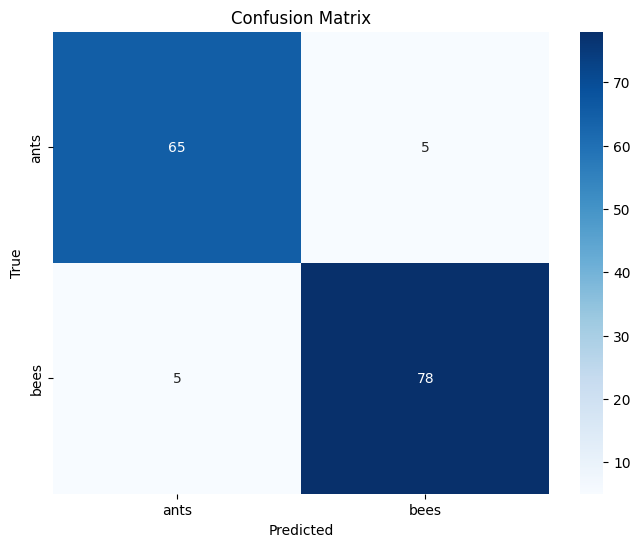

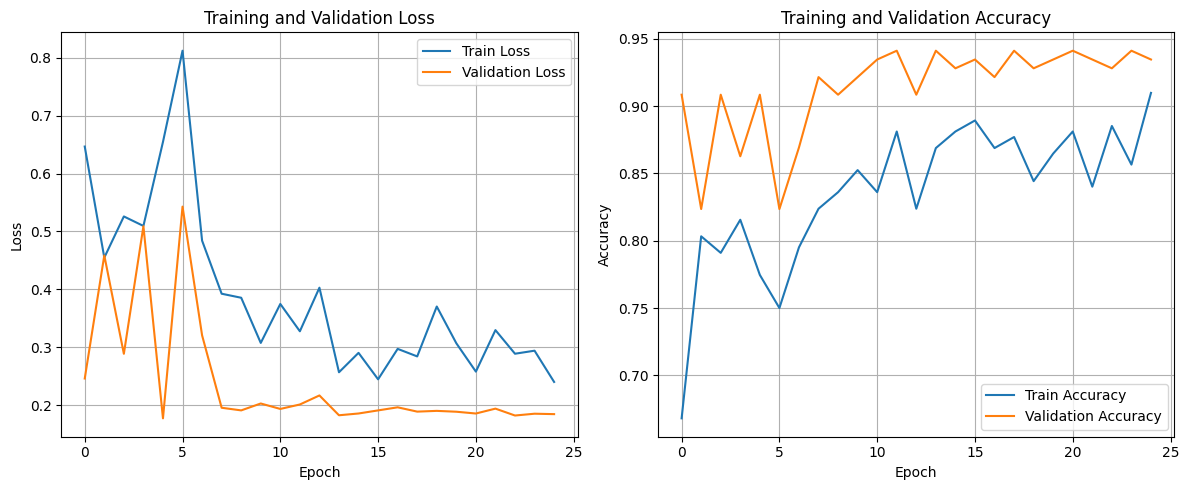

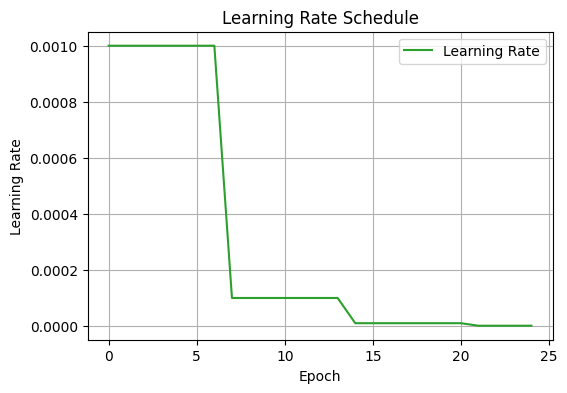

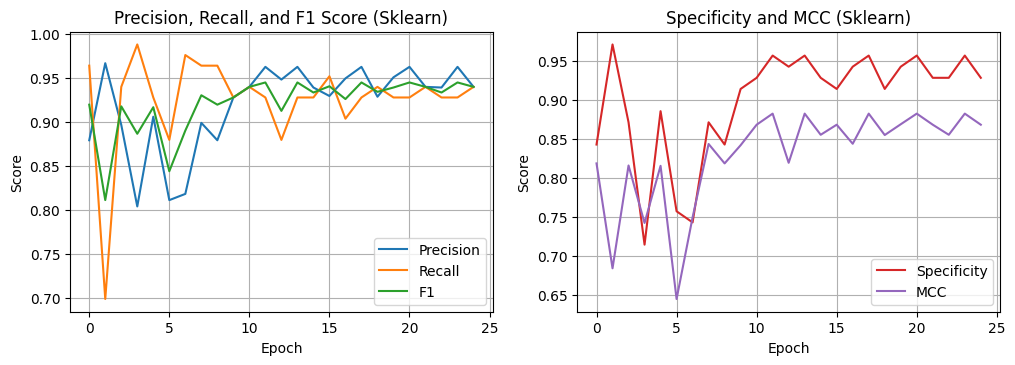

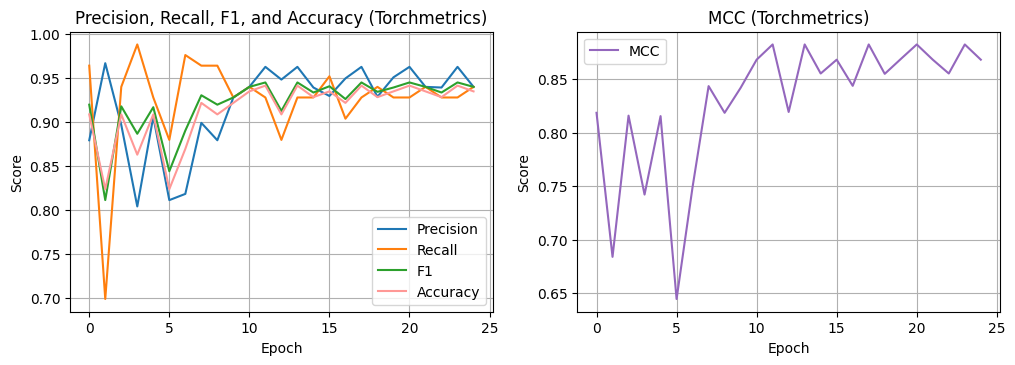

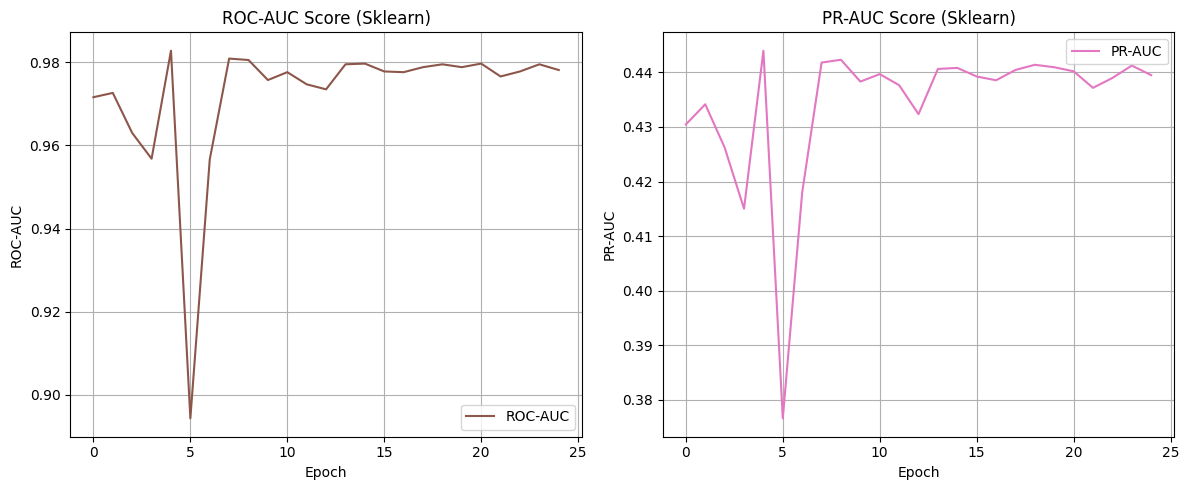

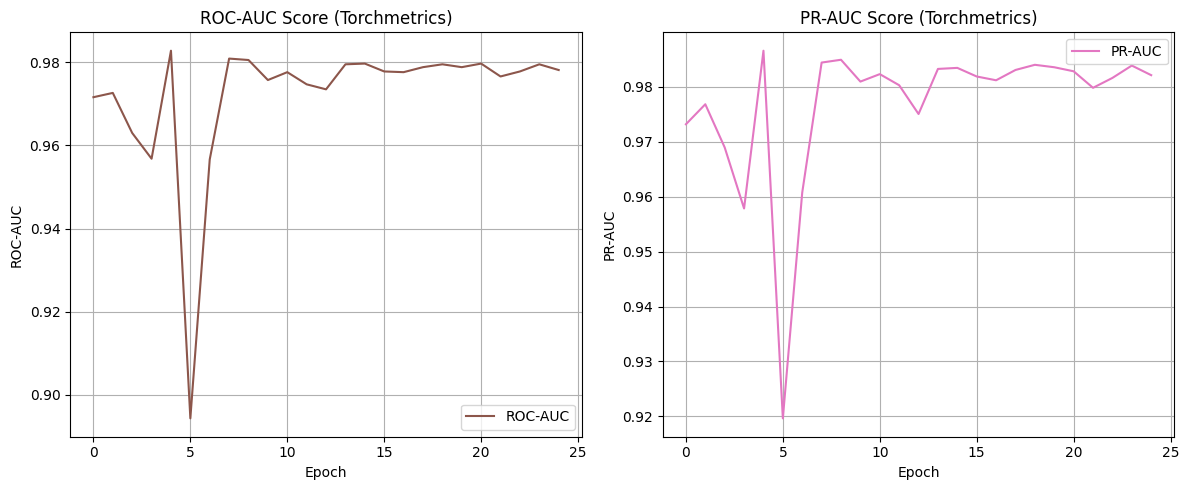

In [128]:
model_ft, metrics, learning_rates, val_metrics = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25, patience=25
)

# Plot training metrics
plot_training_metrics(metrics, learning_rates, val_metrics, plot_roc_pr=True)

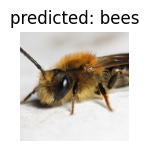

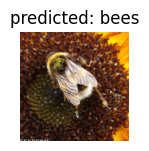

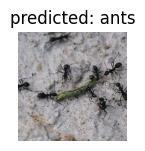

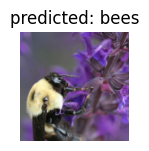

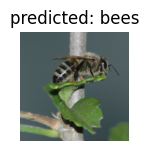

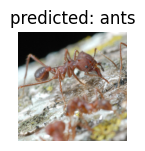

In [68]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

In [133]:
model_conv: nn.Module = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs: int = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion: nn.Module = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv: optim.Optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate

Epoch 0/24
----------
Learning Rate: 0.001000
train Loss: 0.6175 Acc: 0.6680
val Loss: 0.6806 Acc: 0.6797
val Precision_skl: 1.0000, Recall_skl: 0.4096, F1_skl: 0.5812
val Specificity_skl: 1.0000, MCC_skl: 0.4909
val ROC-AUC_skl: 0.9775, PR-AUC_skl: 0.4369
val Precision_torch: 1.0000, Recall_torch: 0.4096, F1_torch: 0.5812
val Accuracy_torch: 0.6797, MCC_torch: 0.4909
val ROC-AUC_torch: 0.9775, PR-AUC_torch: 0.9795

Epoch 1/24
----------
Learning Rate: 0.001000
train Loss: 0.5576 Acc: 0.7500
val Loss: 0.1689 Acc: 0.9412
val Precision_skl: 0.9205, Recall_skl: 0.9759, F1_skl: 0.9474
val Specificity_skl: 0.9000, MCC_skl: 0.8828
val ROC-AUC_skl: 0.9845, PR-AUC_skl: 0.4416
val Precision_torch: 0.9205, Recall_torch: 0.9759, F1_torch: 0.9474
val Accuracy_torch: 0.9412, MCC_torch: 0.8828
val ROC-AUC_torch: 0.9845, PR-AUC_torch: 0.9843

Epoch 2/24
----------
Learning Rate: 0.001000
train Loss: 0.4801 Acc: 0.8115
val Loss: 0.2711 Acc: 0.9346
val Precision_skl: 0.8925, Recall_skl: 1.0000, F1_skl:

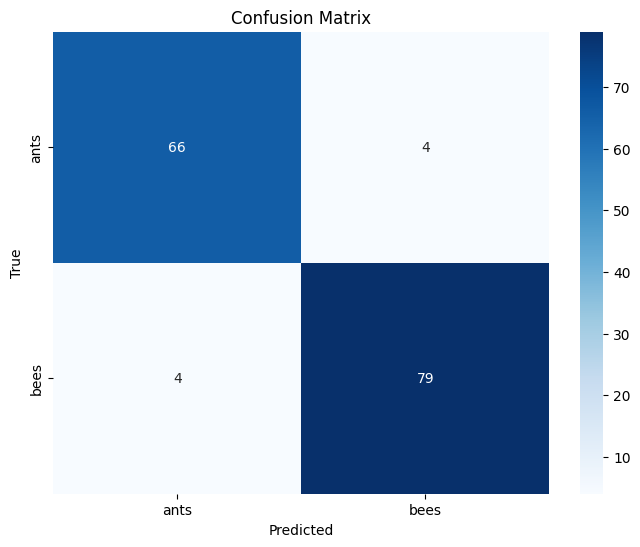

In [130]:
model_conv: nn.Module = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
Learning Rate: 0.001000
train Loss: 0.7140 Acc: 0.6434
val Loss: 0.2224 Acc: 0.9281
val Precision_skl: 0.9615, Recall_skl: 0.9036, F1_skl: 0.9317
val Specificity_skl: 0.9571, MCC_skl: 0.8578
val ROC-AUC_skl: 0.9785, PR-AUC_skl: 0.4411
val Precision_torch: 0.9615, Recall_torch: 0.9036, F1_torch: 0.9317
val Accuracy_torch: 0.9281, MCC_torch: 0.8578
val ROC-AUC_torch: 0.9785, PR-AUC_torch: 0.9836

Epoch 1/24
----------
Learning Rate: 0.001000
train Loss: 0.5473 Acc: 0.7582
val Loss: 0.3778 Acc: 0.8170
val Precision_skl: 0.7477, Recall_skl: 1.0000, F1_skl: 0.8557
val Specificity_skl: 0.6000, MCC_skl: 0.6698
val ROC-AUC_skl: 0.9840, PR-AUC_skl: 0.4433
val Precision_torch: 0.7477, Recall_torch: 1.0000, F1_torch: 0.8557
val Accuracy_torch: 0.8170, MCC_torch: 0.6698
val ROC-AUC_torch: 0.9840, PR-AUC_torch: 0.9859

Epoch 2/24
----------
Learning Rate: 0.001000
train Loss: 0.5557 Acc: 0.7828
val Loss: 0.3679 Acc: 0.8431
val Precision_skl: 0.9836, Recall_skl: 0.7229, F1_skl:

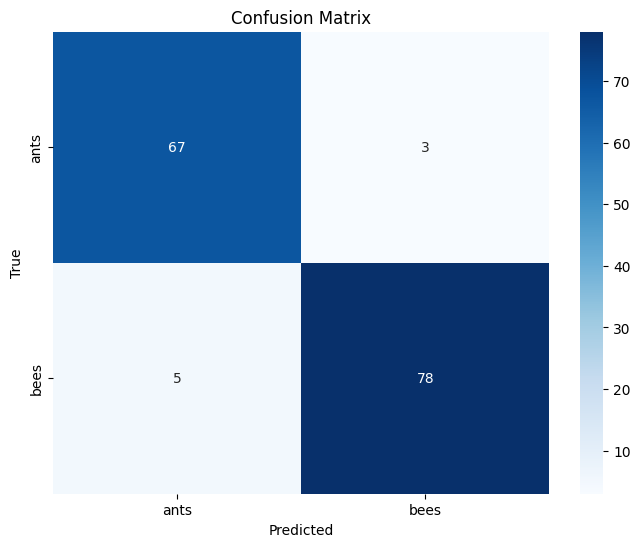

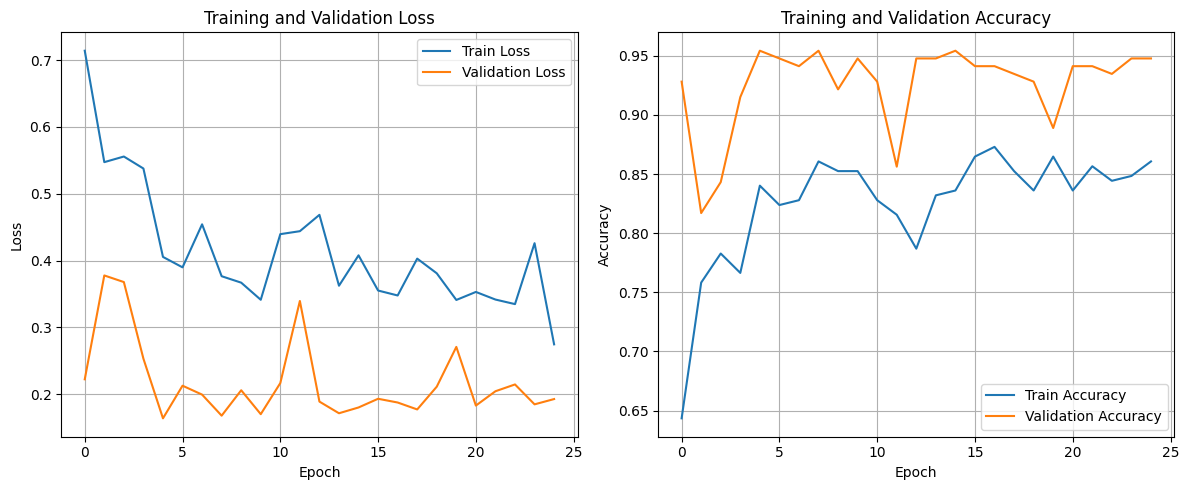

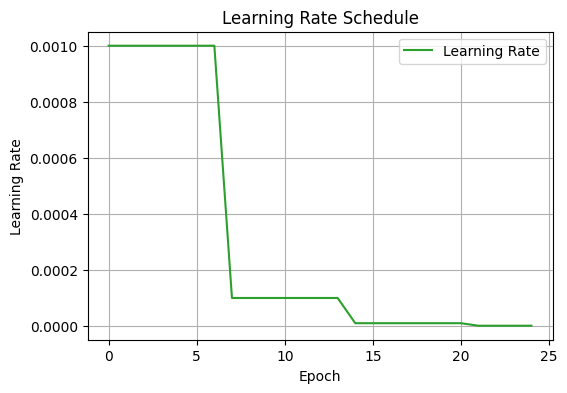

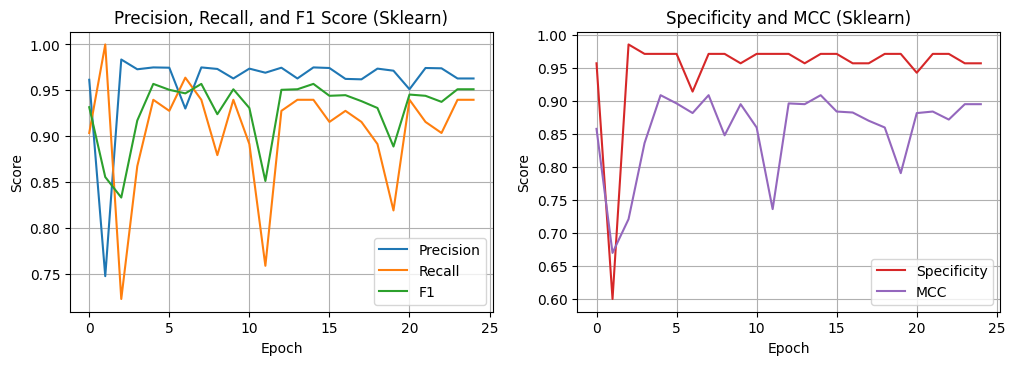

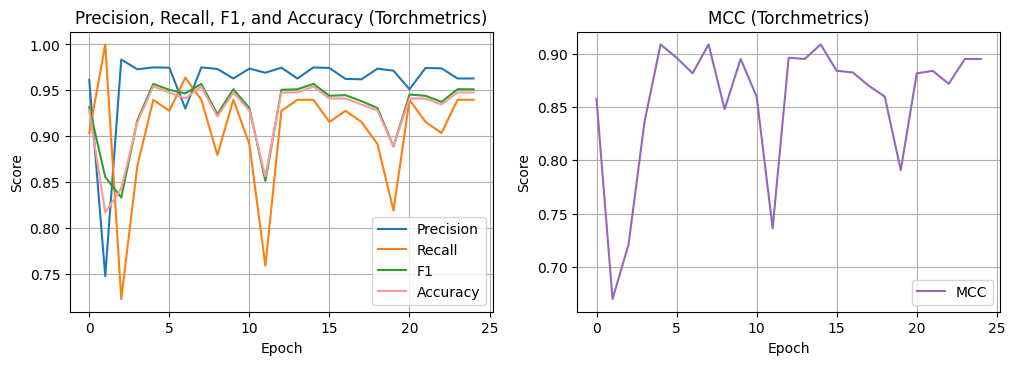

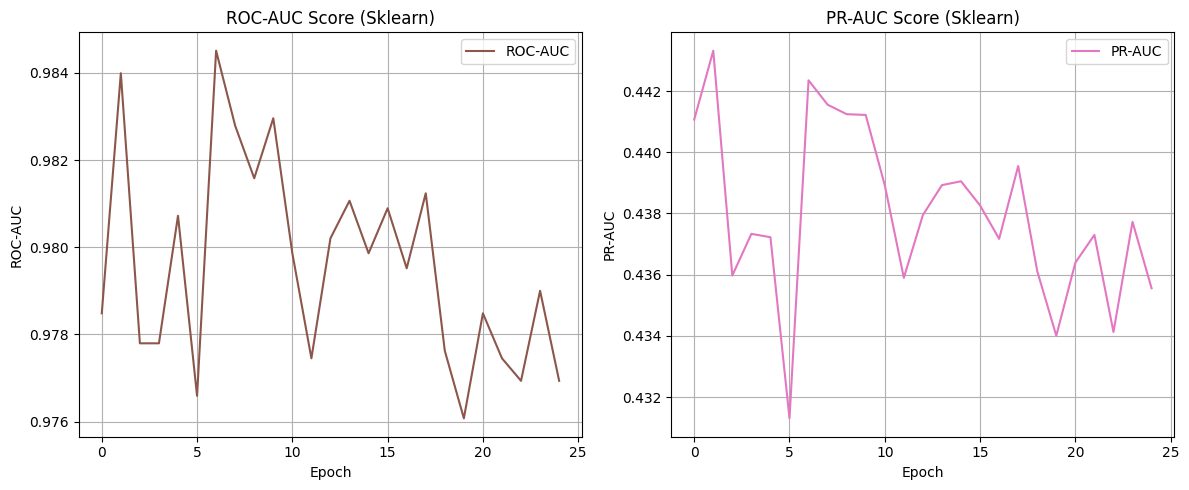

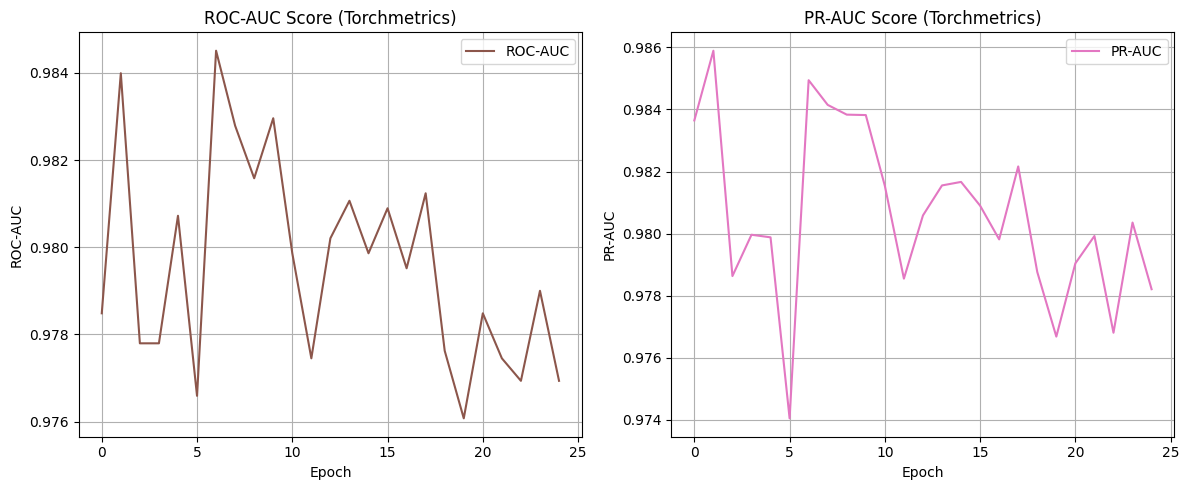

In [134]:
model_ft, metrics, learning_rates, val_metrics = train_model(
    model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25, patience=25
)

# Plot training metrics
plot_training_metrics(metrics, learning_rates, val_metrics, plot_roc_pr=True)

## Visualising

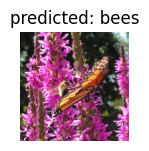

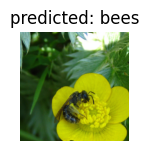

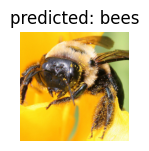

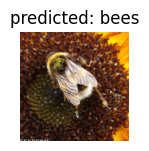

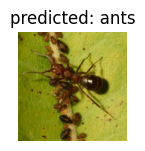

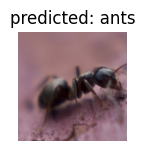

In [135]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Inference on custom images

In [137]:
def visualize_model_predictions(model: nn.Module, img_path: str) -> None:
    was_training: bool = model.training
    model.eval()

    img: Image.Image = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs: torch.Tensor = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

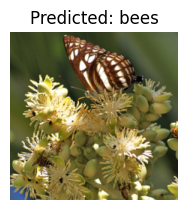

In [138]:
visualize_model_predictions(
    model_conv,
    img_path='/content/drive/MyDrive/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()